In [1]:
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.applications.inception_v3 import InceptionV3 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, log_loss, jaccard_score
import numpy as np
import os
from PIL import Image
from shutil import copyfile  # Import the copyfile function
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shutil
import random
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import warnings

# Ignore DeprecationWarning from Pillow
warnings.filterwarnings("ignore", category=DeprecationWarning)


# **Train Test and Validation Split**

In [3]:
import os
import glob
import shutil
import random

# Define paths
dataset_path = "/kaggle/input/dataset-of-ai-generated-fruits-and-real-fruits/Dataset of AI Generated Fruits and Real Fruits"  # Total Data path colon_image_sets
train_output_path = "/kaggle/working/Train"  # Train data path
test_output_path = "/kaggle/working/Test"  # test data path
val_output_path = "/kaggle/working/Val"  # validation data path

# Create output directories if they don't exist
os.makedirs(train_output_path, exist_ok=True)
os.makedirs(test_output_path, exist_ok=True)
os.makedirs(val_output_path, exist_ok=True)

# List all the class directories in the dataset path
class_dirs = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

# Loop through each class directory and copy files to appropriate splits
for class_dir in class_dirs:
    # Create subdirectories in the output paths
    os.makedirs(os.path.join(train_output_path, class_dir), exist_ok=True)
    os.makedirs(os.path.join(test_output_path, class_dir), exist_ok=True)
    os.makedirs(os.path.join(val_output_path, class_dir), exist_ok=True)

    # List all the nested class directories (e.g., Red Apples, Green Apples)
    nested_class_dirs = [nd for nd in os.listdir(os.path.join(dataset_path, class_dir)) if os.path.isdir(os.path.join(dataset_path, class_dir, nd))]

    for nested_class_dir in nested_class_dirs:
        # Create subdirectories for each nested class directory
        os.makedirs(os.path.join(train_output_path, class_dir, nested_class_dir), exist_ok=True)
        os.makedirs(os.path.join(test_output_path, class_dir, nested_class_dir), exist_ok=True)
        os.makedirs(os.path.join(val_output_path, class_dir, nested_class_dir), exist_ok=True)

        # List all image files in the nested class directory
        files = glob.glob(os.path.join(dataset_path, class_dir, nested_class_dir, '*', '*.jpg'))

        # Shuffle the files to ensure randomness
        random.shuffle(files)

        # Split the files into train, test, and validation sets
        total_samples = len(files)
        train_samples = int(0.7 * total_samples)
        test_samples = int(0.15 * total_samples)
        val_samples = total_samples - train_samples - test_samples

        train_files = files[:train_samples]
        test_files = files[train_samples:train_samples + test_samples]
        val_files = files[train_samples + test_samples:train_samples + test_samples + val_samples]

        # Copy files to the respective output directories
        for src_path in train_files:
            dest_path = os.path.join(train_output_path, class_dir, nested_class_dir, os.path.basename(src_path))
            shutil.copy(src_path, dest_path)

        for src_path in test_files:
            dest_path = os.path.join(test_output_path, class_dir, nested_class_dir, os.path.basename(src_path))
            shutil.copy(src_path, dest_path)

        for src_path in val_files:
            dest_path = os.path.join(val_output_path, class_dir, nested_class_dir, os.path.basename(src_path))
            shutil.copy(src_path, dest_path)


# **Data generators**

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the paths to your train, validation, and test datasets
train_data_dir = '/kaggle/working/Train'
test_data_dir = '/kaggle/working/Test'
validation_data_dir = '/kaggle/working/Val'

# Image dimensions
IMG_WIDTH, IMG_HEIGHT = 299, 299
input_shape = (IMG_WIDTH, IMG_HEIGHT, 3)  # RGB images

# Data generators for RGB images with augmentation
train_datagen_augmented = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen_augmented = ImageDataGenerator(rescale=1./255)
validation_datagen_augmented = ImageDataGenerator(rescale=1./255)

# Generate augmented data for training
train_generator = train_datagen_augmented.flow_from_directory(
    train_data_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=10,
    class_mode='categorical',
    classes=['Ai', 'Real'],
    subset='training'
)

# Generate data for testing
test_generator = test_datagen_augmented.flow_from_directory(
    test_data_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=8,
    class_mode='categorical',
    shuffle=False,
    classes=['Ai', 'Real']
)

# Generate data for validation
validation_generator = validation_datagen_augmented.flow_from_directory(
    validation_data_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=8,
    class_mode='categorical',
    shuffle=True,
    classes=['Ai', 'Real']
)


Found 212 images belonging to 2 classes.
Found 44 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [5]:
class_indices = train_generator.class_indices
print(class_indices)

{'Ai': 0, 'Real': 1}


# **Check for GPU availability**

In [6]:
# Check for GPU availability
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT available")

# Set TensorFlow to use the GPU device
if tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
    print("GPU device configured")
else:
    print("No GPU device found")

GPU is available
GPU device configured


In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint
model_dir = '/kaggle/working/Checkpoints_InceptionV3'

if not os.path.exists(model_dir):
    os.makedirs(model_dir)

checkpoint_path = model_dir + '/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,  # Save only the best model
                                                 monitor="val_accuracy",   # Monitor validation loss
                                                 mode="max",           # Save the model when validation loss is minimized
                                                 verbose=1)

In [8]:
checkpoint_path

'/kaggle/working/Checkpoints_InceptionV3/cp.ckpt'

In [9]:
from tensorflow.keras import models, layers, optimizers

# **InceptionV3 for Feature Extractor**

In [10]:
def create_model(summary=True):
    # apply transfer learning
    new_input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=new_input) ##MobileNetV3Small(weights='imagenet', include_top=False, input_tensor=new_input)
    # add new classifier layers
    flat1 = Flatten()(base_model.layers[-1].output)
    output = Dense(2, activation='softmax')(flat1)  
    # define new model
    model = Model(inputs=base_model.inputs, outputs=output)
    # Modify loss function to 'weighted_binary_crossentropy'
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    if summary:
        print(model.summary())
    return model


In [11]:
model = create_model()

87910968/87910968 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     

In [12]:
# Train the model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[cp_callback]
    
)

Epoch 1/20
22/22 [==============================] - ETA: 0s - loss: 1.0269 - accuracy: 0.8679
Epoch 1: val_accuracy improved from -inf to 0.48000, saving model to /kaggle/working/Checkpoints_InceptionV3/cp.ckpt
22/22 [==============================] - 53s 753ms/step - loss: 1.0269 - accuracy: 0.8679 - val_loss: 522.4016 - val_accuracy: 0.4800
Epoch 2/20
22/22 [==============================] - ETA: 0s - loss: 1.3150 - accuracy: 0.8491
Epoch 2: val_accuracy improved from 0.48000 to 0.52000, saving model to /kaggle/working/Checkpoints_InceptionV3/cp.ckpt
22/22 [==============================] - 14s 610ms/step - loss: 1.3150 - accuracy: 0.8491 - val_loss: 698777.0625 - val_accuracy: 0.5200
Epoch 3/20
22/22 [==============================] - ETA: 0s - loss: 0.7011 - accuracy: 0.9151
Epoch 3: val_accuracy did not improve from 0.52000
22/22 [==============================] - 12s 547ms/step - loss: 0.7011 - accuracy: 0.9151 - val_loss: 227394.8750 - val_accuracy: 0.5200
Epoch 4/20
22/22 [====

In [13]:
# Save the training history
initial_epoch = 0  # or the actual initial epoch of the first training session
saved_history = {
    'loss': history.history['loss'],
    'accuracy': history.history['accuracy'],
    'val_loss': history.history['val_loss'],
    'val_accuracy': history.history['val_accuracy'],
    
}


In [14]:
np.save("/kaggle/working/saved_inceptionv3history.npy", saved_history)

In [15]:
# Load the latest checkpoint file
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
print(latest_checkpoint)

if latest_checkpoint is not None:
    # Create a new model instance
    loaded_model = create_model(summary=True)

    # Load the previously saved weights and silence the warnings
    status = loaded_model.load_weights(latest_checkpoint)
    status.expect_partial()  # Ignore unrestored variables
else:
    print("No checkpoint file found in the specified directory.")

/kaggle/working/Checkpoints_InceptionV3/cp.ckpt
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 149, 149, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 149, 149, 32)         96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 149, 149

# **Evaluate the model on the test set**

In [16]:
test_loss, test_acc = loaded_model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")

6/6 [==============================] - 5s 442ms/step - loss: 0.0183 - accuracy: 1.0000
Test Accuracy: 1.0


In [17]:
# Predict labels for the test set
predictions = loaded_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)  # Get the index of the highest probability class
true_classes = test_generator.classes

# Display some of the predicted and true classes
print("Predicted Classes:", predicted_classes[-10:])  # Display first 10 predicted classes
print("True Classes:", true_classes[-10:])  # Display first 10 true classes


6/6 [==============================] - 3s 230ms/step
Predicted Classes: [1 1 1 1 1 1 1 1 1 1]
True Classes: [1 1 1 1 1 1 1 1 1 1]


In [18]:
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes,digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        22
           1     1.0000    1.0000    1.0000        22

    accuracy                         1.0000        44
   macro avg     1.0000    1.0000    1.0000        44
weighted avg     1.0000    1.0000    1.0000        44



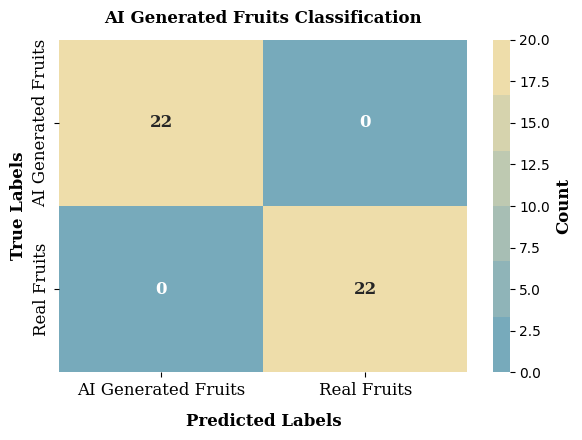

In [19]:
# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(6, 4.5))
# Define the custom palette
custom_palette = sns.color_palette(palette='blend:#7AB,#EDA')# Modify the number based on number of classes in the dataset
# Define custom font dictionary for title and labels
font = {'family': 'Serif', 'weight': 'bold', 'size': 12}

# Create heatmap with annotations and colormap
heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=custom_palette,vmin=0,vmax=20,
                      xticklabels=['AI Generated Fruits', 'Real Fruits'], yticklabels=['AI Generated Fruits', 'Real Fruits'],annot_kws={"family": "Serif",'weight': 'bold', 'size': 12})

# Set x and y labels with the custom font dictionary
heatmap.set_xlabel('Predicted Labels', fontdict=font)
heatmap.set_ylabel('True Labels', fontdict=font)
heatmap.set_title('AI Generated Fruits Classification', fontdict=font, pad=12)

# Set font properties for tick labels on both axes
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontname='Serif', fontsize=12)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontname='Serif', fontsize=12)

# Create a color bar to indicate the scale
cbar = heatmap.collections[0].colorbar
cbar.set_label('Count', fontdict=font)
cbar.ax.tick_params(labelsize=10)
# Adjust padding between x-axis label and x-axis ticks
plt.gca().xaxis.labelpad = 10  # Change the value as needed to adjust the space
# Adjust layout to prevent cropping
plt.tight_layout()
plt.show()


# **Checking model predictions for random images from test dataset**

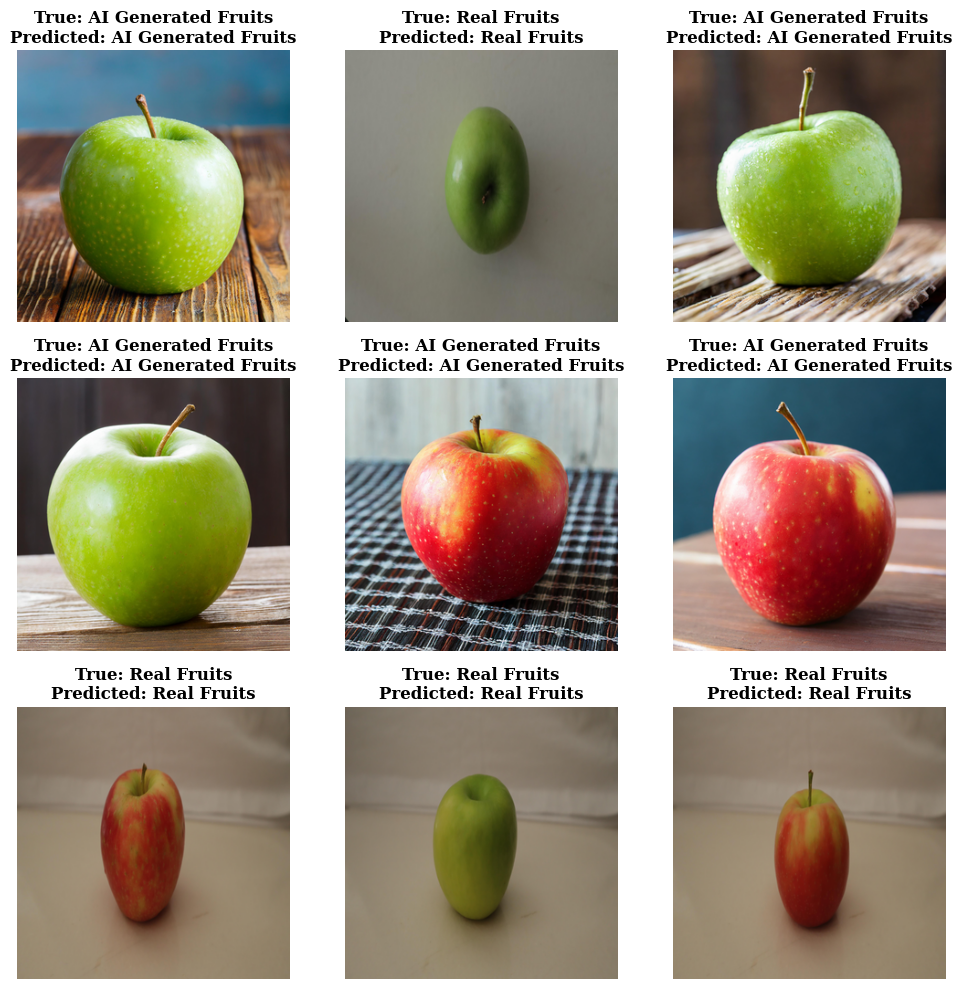

In [20]:
import random
import matplotlib.pyplot as plt
import cv2
from PIL import Image

# Get random indices for three images
random_indices = random.sample(range(len(true_classes)), 9)

plt.figure(figsize=(10, 10))
for i, idx in enumerate(random_indices, 1):
    # Load the image
    img_path = test_generator.filepaths[idx]
    img = Image.open(img_path)

    # Resize the image to 299x299 pixels without changing the color space
    img = img.resize((299, 299), Image.ANTIALIAS)

    # Convert PIL image to numpy array without color space conversion
    img_array = np.array(img)

    # Display the image
    plt.subplot(3, 3, i)
    plt.imshow(img_array)
    plt.axis('off')

    # Display the true and predicted labels
    true_label = "AI Generated Fruits" if true_classes[idx] == 0 else "Real Fruits"
    predicted_label = "AI Generated Fruits" if predicted_classes[idx] == 0 else "Real Fruits"

    plt.title(f"True: {true_label}\nPredicted: {predicted_label}", fontdict={'family': 'Serif', 'weight': 'bold', 'size': 12})

plt.tight_layout()
plt.show()
